In [1]:
import gc   # For manual garbage collection.
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
from numba import njit
import math

experiment = 'Exp1'

# Import and select data.
all_data = pd.read_csv('total_data.csv',
    usecols = ['gps.lat', 'gps.lon', 'altitudeRelative', 'Concentration', 'Experiment'],
)
all_data = all_data[all_data['Experiment'] == experiment]
all_data = all_data.drop(columns = ['Experiment'])

# Import and select metadata.
experiment_metadata = pd.read_csv('data_summary.csv',
    usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
)
experiment_metadata = experiment_metadata[experiment_metadata['Experiment'] == experiment]
wind_dir = experiment_metadata['Wind_Dir'].values[0]
wind_speed = experiment_metadata['WindSpeed'].values[0]

# Converting lat and lon to distances from boat in downwind and crosswind directions.
all_data['dist_lat'] = (all_data['gps.lat'] - experiment_metadata['boat.lat'].values[0]) * 111000
all_data['dist_lon'] = (all_data['gps.lon'] - experiment_metadata['boat.lon'].values[0]) * 111000
all_data['x'] = all_data['dist_lon'] * np.cos(270 - wind_dir) + all_data['dist_lat'] * np.sin(270 - wind_dir)
all_data['y'] = all_data['dist_lon'] * np.cos(360 - wind_dir) + all_data['dist_lat'] * np.sin(360 - wind_dir)
all_data['z'] = all_data['altitudeRelative']

# Modify concentrations.
all_data['Concentration'] = all_data['Concentration']

# Split data, 80% for training and 20% for testing, shuffling rows first.
all_data = all_data.drop(columns = ['altitudeRelative', 'dist_lat', 'dist_lon', 'gps.lat', 'gps.lon'])
all_data = np.asarray(all_data)   # Prepare for Numba.
np.random.seed(1)                 # Ensure the same split each time.
np.random.shuffle(all_data)
training_data, testing_data = np.split(all_data, [int(0.8 * len(all_data))])

# Release unused memory.
del(all_data)
del(experiment)
del(experiment_metadata)
del(wind_dir)
gc.collect()

0

In [16]:
# Inference and model parameters.
H = 0

ss =np.array([0.1, 0.1, 100,100])

prior_param_1 = np.array([0.33, 0.86, 1000, 800])
prior_param_2 = np.array([1, 1, 100, 100])
dists = ['gamma','gamma','gamma','gamma']

params_init = prior_param_1.copy()


class Sampler:
    def __init__(self,H, wind_speed, ss, data, dist, prior_param_1, prior_param_2):
        self.H = H
        self.u = wind_speed 
        self.ss = ss
        self.data = data
        self.dist = dist
        self.prior_param_1 = prior_param_1
        self.prior_param_2 = prior_param_2
        self.N_data = data[:,1].size
        
    # Function for calculating the conditional probability for parameters a, b or Q.
    def log_prob_params(self,params, log_lhood, param_select):
        if self.dist[param_select] == 'gamma':
            prob = (self.prior_param_1[param_select] - 1)*np.log(params[param_select])-params[param_select]/self.prior_param_2[param_select]+log_lhood
        elif self.dist[param_select] == 'gaussian':
            prob =  -(params[param_select]-self.prior_param_1[param_select])**2/(2*self.prior_param_2[param_select]**2)+log_lhood        
        elif self.dist[param_select] == 'uniform':
            prob = log_lhood
        return  prob

    def step(self,param_select, current_params):
        if self.dist[param_select] == "gamma":
            return np.random.gamma(current_params[param_select],self.ss[param_select])
        if self.dist[param_select] == "gaussian":
            return np.random.normal(current_params[param_select],self.ss[param_select])
        if self.dist[param_select] == "uniform":
            return np.random.normal(current_params[param_select],self.ss[param_select])
    
    # MCMC Sampler for a, b or Q.
    def sample_params(self,params, precalc2, param_select):

        # Set current and proposed values for a, b, Q and sigma.
        current_params = params
        proposed_params = current_params.copy()
        proposed_params[param_select] =  self.step(param_select,current_params)

        condition = [0,0,0,1]

        # Calculating the conditional probability of current and proposed a,b,Q and sigma.
        log_l_curr_params = -sum(precalc2)/(2*current_params[3]**2) - self.N_data*np.log(np.sqrt(2*np.pi)*current_params[3])*condition[param_select]
        log_l_prop_params = -sum(precalc2)/(2*proposed_params[3]**2) - self.N_data*np.log(np.sqrt(2*np.pi)*proposed_params[3])*condition[param_select]

        log_p_prop_params = self.log_prob_params(proposed_params, log_l_prop_params, param_select)
        log_p_curr_params = self.log_prob_params(current_params, log_l_curr_params, param_select)
        
        # Calculating the probability of stepping (for the Metropolis Hastings Acceptance Criteria)
        log_p_step_back, log_p_step_forward = self.get_p_step_back_forward(param_select, current_params, proposed_params)       
        
        # Acceptance criteria
        alpha = np.exp(log_p_prop_params - log_p_curr_params + log_p_step_back - log_p_step_forward)
    
        # Acceptance criteria.
        if np.random.uniform(low = 0, high = 1) < np.min([1,alpha]):
            return proposed_params, 1
        else:
            return current_params, 0

    def get_p_step_back_forward(self, param_select, current_params, proposed_params):
        if self.dist[param_select] == 'gaussian':
            return 1, 1

        elif self.dist[param_select] == 'uniform':
            return 1, 1
        
        elif self.dist[param_select] == 'gamma':
            back = stats.gamma.logpdf(current_params[param_select], proposed_params[param_select], scale=1/self.ss[param_select])
            forward = stats.gamma.logpdf(proposed_params[param_select], current_params[param_select], scale=1/self.ss[param_select])
            return back, forward
            
    # Full MCMC sampler.
    def sample_process(self,N_samples):
        # Intialisation. Pre-allocate memory space for the data where relevant.
        params_means = np.empty((N_samples, len(params_init)))    # rows = N_samples, cols = len(params_init).
        params_means[:] = np.NaN
        params_samples = params_means.copy()
        params = params_init
        count = 0
        negysqr = -self.data[:,2]**2
        piu = np.pi * self.u
        zdownsqr = -(self.data[:,3] - H)**2
        zupsqr = -(self.data[:,3] + H)**2

        accept_tot_0, accept_tot_1, accept_tot_2, accept_tot_3 = 0, 0, 0, 0

        tot_accepted = 0
        for j in range(N_samples):
            count += 1
            if (count % 1000 == 0):
                print('Running sample ' + str(count) + '...')    # Print progress every 1000th sample.

            precalc1 = 2 * params[0] * self.data[:,1]**params[1]
            precalc2 = (params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - self.data[:,0])**2

            params, accept_0 = self.sample_params(params,precalc2,0) # a
            params, accept_1 = self.sample_params(params,precalc2,1) # b
            params, accept_2 = self.sample_params(params,precalc2,2) # Q 
            params, accept_3 = self.sample_params(params,precalc2,3) # sigma

            accept_tot_0 += accept_0
            accept_tot_1 += accept_1
            accept_tot_2 += accept_2
            accept_tot_3 += accept_3

            params_samples[j] = params.T
            params_means[j] = np.mean(params_samples[:count][:], axis = 0)

        print('Sampling complete.')
        print('a Acceptance Rate: ', accept_tot_0/N_samples)
        print('b Acceptance Rate: ', accept_tot_1/N_samples)
        print('Q Acceptance Rate: ', accept_tot_2/N_samples)
        print('sigma Acceptance Rate: ', accept_tot_3/N_samples)

        return params_samples, params_means


# Run sampling.
np.random.seed(117)
sampler = Sampler(H, wind_speed, ss, training_data, dists, prior_param_1, prior_param_2)
params_samples, params_means = sampler.sample_process(1000)

C:\Users\Sam\AppData\Local\Temp\ipykernel_18260\143042013.py:64: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(log_p_prop_params - log_p_curr_params + log_p_step_back - log_p_step_forward)
C:\Users\Sam\AppData\Local\Temp\ipykernel_18260\143042013.py:55: RuntimeWarning: overflow encountered in double_scalars
  log_l_prop_params = -sum(precalc2)/(2*proposed_params[3]**2) - self.N_data*np.log(np.sqrt(2*np.pi)*proposed_params[3])*condition[param_select]
C:\Users\Sam\AppData\Local\Temp\ipykernel_18260\143042013.py:54: RuntimeWarning: overflow encountered in double_scalars
  log_l_curr_params = -sum(precalc2)/(2*current_params[3]**2) - self.N_data*np.log(np.sqrt(2*np.pi)*current_params[3])*condition[param_select]
C:\Users\Sam\AppData\Local\Temp\ipykernel_18260\143042013.py:28: RuntimeWarning: divide by zero encountered in log
  prob = (self.prior_param_1[param_select] - 1)*np.log(params[param_select])-params[param_select]/self.prior_param_2[param_select]+log_lhood


[7.60627988e-003 4.25640427e-002 1.00507865e+211 8.03114105e+210]
[1.05378489e-003 4.25640427e-002 1.00507865e+221 8.03114105e+220]
[1.05378489e-003 4.25640427e-002 1.00507865e+223 8.03114105e+222]
[1.05378489e-003 4.25640427e-002 1.00507865e+229 8.03114105e+228]
[1.05378489e-003 5.01120575e-002 1.00507865e+243 8.03114105e+242]
[1.05378489e-003 5.01120575e-002 1.00507865e+253 8.03114105e+252]
[1.05378489e-003 4.99057302e-002 1.00507865e+261 8.03114105e+260]
[1.05378489e-003 4.99057302e-002 1.00507865e+263 8.03114105e+262]
[1.05378489e-003 4.99057302e-002 1.00507865e+267 8.03114105e+266]
[1.05378489e-003 4.99057302e-002 1.00507865e+271 8.03114105e+270]
[1.05378489e-003 4.99057302e-002 1.00507865e+275 8.03114105e+274]
[1.05378489e-003 4.99057302e-002 1.00507865e+277 8.03114105e+276]
[1.05378489e-003 4.99057302e-002 1.00507865e+281 8.03114105e+280]
[1.05378489e-003 4.99057302e-002 1.00507865e+285 8.03114105e+284]
[1.05378489e-003 4.99057302e-002 1.00507865e+287 8.03114105e+286]
[1.0537848

C:\Users\Sam\AppData\Local\Temp\ipykernel_18260\143042013.py:109: RuntimeWarning: overflow encountered in multiply
  precalc2 = (params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - self.data[:,0])**2
C:\Users\Sam\AppData\Local\Temp\ipykernel_18260\143042013.py:109: RuntimeWarning: invalid value encountered in multiply
  precalc2 = (params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - self.data[:,0])**2


[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
[1.0537848

In [17]:
# Utility function for traceplots.
def traceplots(x, xnames = None, title = None):

    N, d = x.shape
    fig = plt.figure()
    left, tracewidth, histwidth = 0.1, 0.65, 0.15
    bottom, rowheight = 0.1, 0.8/d
    spacing = 0.05

    for i in range(d):
        # Set the location of the trace and histogram viewports,
        # starting with the first dimension from the bottom of the canvas.
        rowbottom = bottom + i * rowheight
        rect_trace = (left, rowbottom, tracewidth, rowheight)
        rect_hist = (left + tracewidth, rowbottom, histwidth, rowheight)

        # First set of trace plot axes.
        if i == 0:
            ax_trace = fig.add_axes(rect_trace)
            ax_trace.plot(x[:,i])
            ax_trace.set_xlabel("Sample Count")
            ax_tr0 = ax_trace

        # Other sets of trace plot axes that share the first trace's x-axis.
        # Make tick labels invisible so they don't clutter up the plot.
        elif i > 0:
            ax_trace = fig.add_axes(rect_trace, sharex=ax_tr0)
            ax_trace.plot(x[:,i])
            plt.setp(ax_trace.get_xticklabels(), visible=False)

        # Title at the top.
        if i == d-1 and title is not None:
            plt.title(title)

        # Trace y-axis labels.
        if xnames is not None:
            ax_trace.set_ylabel(xnames[i])

        # Trace histograms at the right.
        ax_hist = fig.add_axes(rect_hist, sharey=ax_trace)
        ax_hist.hist(x[:,i], orientation='horizontal', bins=50)
        plt.setp(ax_hist.get_xticklabels(), visible=False)
        plt.setp(ax_hist.get_yticklabels(), visible=False)
        xlim = ax_hist.get_xlim()
        ax_hist.set_xlim([xlim[0], 1.1*xlim[1]])

[[3.30000000e-001 2.07393152e-001 1.00290559e+005 8.00758062e+004]
 [3.30000000e-001 2.07393152e-001 1.00509968e+007 8.03200881e+006]
 [1.60388289e-002 2.07393152e-001 1.00504663e+009 8.03084098e+008]
 ...
 [1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
 [1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]
 [1.05378489e-003 4.99057302e-002 1.00507865e+305 8.03114105e+304]]


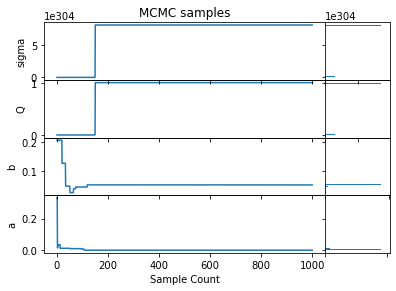

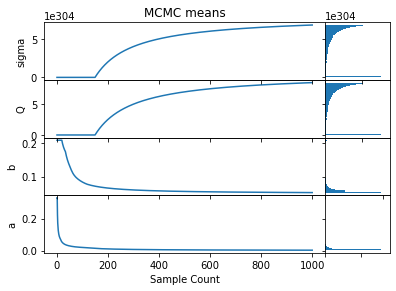

In [5]:
traceplots(params_samples, xnames = ['a', 'b', 'Q','sigma'], title = 'MCMC samples')
traceplots(params_means, xnames = ['a', 'b', 'Q','sigma'], title = 'MCMC means')

print(params_samples)

In [6]:
# Gaussian Plume Model for concentration.
def C_func(x,y,z,u,a,b,Q,H):
    C = Q / (2*a*x**b*np.pi*u)*(np.exp(-(y**2)/(2*a*x**b)))*(np.exp(-(z-H)**2/(2*a*x**b))+np.exp(-(z+H)**2/(2*a*x**b)))
    return C

Inferred means: a = 0.0, b = 0.05, Q = 8.543270052214675e+304, sigma = 6.826551017596193e+304.


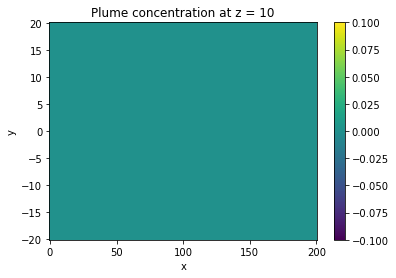

In [7]:
# Plotting slices of the plume at set Z values using the mean values of the parameters.

params_mean = params_means[-1]
x = np.linspace(0.1, 200, 201)
y = np.linspace(-20, 20, 201)
#z = np.linspace(0, 400, 201)
X,Y = np.meshgrid(x, y)
Z = 10
C = C_func(X, Y, Z, wind_speed, params_mean[0], params_mean[1], params_mean[2], H)
plt.pcolor(X, Y, C, shading = 'auto')
plt.colorbar()
plt.title('Plume concentration at z = ' + str(Z))
plt.xlabel('x')
plt.ylabel('y')
print('Inferred means: a = ', round(params_mean[0], 2), ', b = ', round(params_mean[1], 2), ', Q = ', params_mean[2], ', sigma = ',  params_mean[3], '.', sep = '')

del(x)
del(y)

In [8]:
# Calculating the RMSE of this new model based on the data
def RMSE_func(params, u, H, data):

    # Gaussian Plume Model for concentration.

    negysqr = -data['y']**2
    piu = np.pi * u
    zdownsqr = -(data['z'] - H)**2
    zupsqr = -(data['z'] + H)**2
    precalc1 = np.array(2 * params[0] * data['x']**params[1])
    precalc2 = (params[2] / precalc1 * piu * np.exp(negysqr / precalc1) * (np.exp(zdownsqr / precalc1) + np.exp(zupsqr / precalc1)) - data['Concentration'])**2

    RMSE = np.sqrt(sum(precalc2)/data.shape[0])
    print('RMSE = ' + str(RMSE))
    return RMSE


RMSE = RMSE_func(params_mean, wind_speed, H, testing_data)

data_range = np.max(testing_data['Concentration']) - np.min(testing_data['Concentration'])

print('Range = ' + str(data_range))

# # saving_samples = pd.DataFrame({'a':abQ_samples[:,0],'b':abQ_samples[:,1],'Q':abQ_samples[:,2]})
# saving_samples = pd.DataFrame(abQ_samples,columns=['a','b','Q'])
# saving_samples.to_csv('samples.csv')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Print the values of a, b and Q
def print_vals(params_samples):

    params_samples = np.array(params_samples)
    vals = ['a','b','Q','sigma']
    for i in range(params_samples.shape[1]):
        param_samples = params_samples[:,i]
        param_90 = np.sort(param_samples)[int(np.floor(param_samples.size*0.9))]
        param_50 = np.sort(param_samples)[int(np.floor(param_samples.size*0.5))]
        param_10 = np.sort(param_samples)[int(np.floor(param_samples.size*0.1))]

        print(vals[i] + ' Mean = ' + str(np.mean(params_samples[:,i])) + ', Confidence ' + str([param_10,param_90]))
        
print_vals(params_samples)